In [1]:
# autodl内置学术资源加速
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value
os.environ['HF_HOME'] = '/root/autodl-tmp/cache/'

In [2]:
class EXP:
    MODEL = [
            '/root/autodl-fs/hf-checkpoints/sentence-transformers/sentence-t5-base',
            '/root/autodl-fs/hf-checkpoints/Alibaba-NLP/gte-base-en-v1.5',
            '/root/autodl-fs/hf-checkpoints/BAAI/bge-base-en-v1.5',
            '/root/autodl-fs/hf-checkpoints/hkunlp/instructor-base',
            '/root/autodl-fs/hf-checkpoints/intfloat/e5-base',
            '/root/autodl-fs/hf-checkpoints/princeton-nlp/sup-simcse-bert-base-uncased',
            '/root/autodl-fs/hf-checkpoints/sentence-transformers/all-mpnet-base-v2',
            '/root/autodl-fs/hf-checkpoints/WhereIsAI/UAE-Large-V1'
            ]

    DATASET = [
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts13-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts22-crosslingual-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts12-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/stsbenchmark-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sickr-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts14-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/biosses-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts16-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts15-sts",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/stsb_multi_mt",
        "G:\juchiyun2024-11-14/hf_dataset/mteb/sts17-crosslingual-sts"
    ]
    SENT_PAIR_NUM = 5
    INSERT_NUM = 8
    VERIFICATION_SENT_PAIR_NUM = 250

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('/root/StickyToken')
# from stickytoken.utils import *

In [4]:
import pandas as pd

df = pd.DataFrame()

import numpy as np
np.random.seed(42)
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
def check_embeddings_is_anisotropic(all_embeddings: np.ndarray,
                                     batch_size=128,
                                     plot=False)->list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_embeddings = torch.tensor(all_embeddings, dtype=torch.float16).to(device)

    # 计算向量之间的模长
    vector_norms = torch.norm(all_embeddings, dim=1)

    # 计算向量之间的余弦相似度
    cosine_similarities = []

    for i in tqdm(range(0, all_embeddings.shape[0], batch_size), desc="计算余弦相似度",miniters=10):
        batch_embeddings = all_embeddings[i:i+batch_size]
        batch_norms = vector_norms[i:i+batch_size]
        for j in range(batch_embeddings.shape[0]):
            cosine_similarity = torch.matmul(batch_embeddings[j], all_embeddings.T) / (batch_norms[j] * vector_norms)
            cosine_similarities.append(cosine_similarity.cpu().numpy())

    # 将cosine_similarities展平成一个numpy数组并转换为bf16精度
    cosine_similarities_np = np.concatenate(cosine_similarities).flatten().astype(np.float16) #展平成一维数组(vocab_size^2,)

    sample_size = min(30000, len(cosine_similarities_np))  # 取样以加快速度
    sample_indices = np.random.choice(len(cosine_similarities_np), sample_size, replace=False)
    sampled_cosine_similarities = cosine_similarities_np[sample_indices]
    
    if plot:
        # 画出余弦距离的分布图和密度估计曲线
        plt.figure(figsize=(8, 4))
        plt.hist(cosine_similarities_np, bins=50, alpha=0.75, color='blue', edgecolor='black', density=True)
        
        # 添加密度估计曲线
        import seaborn as sns
        # sns.kdeplot(cosine_similarities_np, color='red', linewidth=2) #运行很慢,cosine_similarities_np.shape=(vocab_size^2,)，这个数量级太大了
        sample_size = min(1000, len(cosine_similarities_np))  # 取样以加快速度
        sample_indices = np.random.choice(len(cosine_similarities_np), sample_size, replace=False)
        sampled_cosine_similarities = cosine_similarities_np[sample_indices]
        sns.kdeplot(sampled_cosine_similarities, color='red', linewidth=2)

        plt.title('Distribution of Cosine Similarity between Token Embeddings')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Density/Frequency')
        plt.grid(True)
        plt.show()

    return sampled_cosine_similarities

In [ ]:
from stickytoken.embedding_model import ModelAnalyzer
for model_path in EXP.MODEL:
    moda = ModelAnalyzer(model_path)
    sim_np = check_embeddings_is_anisotropic(moda.vocab_embeddings, plot=False)
    df[moda.model_name] = sim_np
    torch.cuda.empty_cache()

In [ ]:
df

In [ ]:
#保存df
df.to_csv('anisotropic.csv',index=False)

In [5]:
df = pd.read_csv('anisotropic.csv')
df.rename(columns={'sup-simcse-bert-base-uncased': 'simcse-bert-base'}, inplace=True)
df.head()

,sentence-t5-base,gte-base-en-v1.5,bge-base-en-v1.5,instructor-base,e5-base,simcse-bert-base,all-mpnet-base-v2,UAE-Large-V1
0,0.7573,0.3477,0.5977,0.8525,0.7344,0.6836,0.1766,0.4404
1,0.7886,0.3190,0.4644,0.8384,0.7360,0.6360,0.1667,0.5107
2,0.7950,0.4587,0.4827,0.8270,0.8037,0.5350,0.1401,0.4185
3,0.8037,0.5240,0.6060,0.7870,0.7866,0.4827,0.2236,0.4578
4,0.8003,0.2778,0.4870,0.8370,0.7150,0.5740,0.1511,0.5620


In [6]:
my_df = pd.melt(df, var_name='model', value_name='cosine_similarity')
my_df

,model,cosine_similarity
0,sentence-t5-base,0.7573
1,sentence-t5-base,0.7886
2,sentence-t5-base,0.7950
3,sentence-t5-base,0.8037
4,sentence-t5-base,0.8003
...,...,...
239995,UAE-Large-V1,0.5137
239996,UAE-Large-V1,0.4958
239997,UAE-Large-V1,0.5786
239998,UAE-Large-V1,0.5938


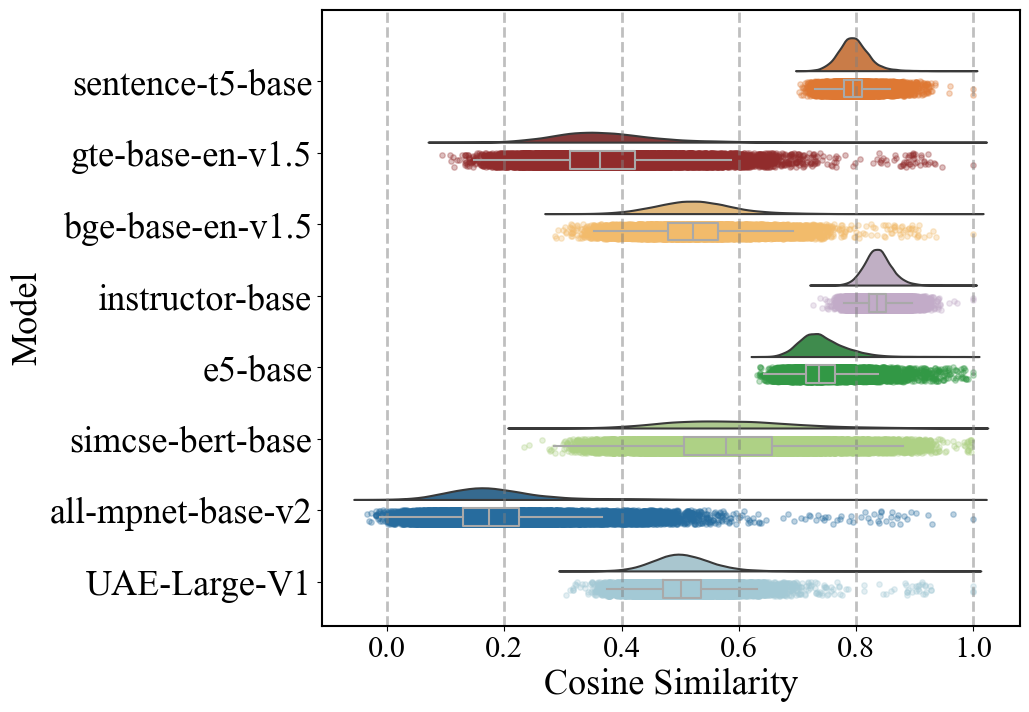

In [21]:
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 24,
    'font.family': 'Times New Roman'
})

# Define properties for the boxplot
medianprops = {"linewidth": 1.5, "color": "#a9a9a9", "solid_capstyle": "butt"}
boxprops = {"linewidth": 1.5, "color": "#a9a9a9"}

#basename
MODELS = df.columns.to_list()
COLORS = ["#DE7833", "#912C2C", "#F2BB6B", "#C2ABC8", "#329845", "#AED185", "#276C9E", "#A3C9D5"][:len(MODELS)]

# Create our own Axes with custom size
fig, ax = plt.subplots(figsize=(9, 8))

# 设置边框线宽
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# inner=None removes the default boxplot
# The 'width' argument allows us to scale the density
# We pass our color palette in the 'palette' argument
pt.half_violinplot(
    x='cosine_similarity', y='model', scale='area', palette=COLORS, 
    inner=None, data=my_df, width=1, ax=ax
)

# Iterate over the models
for i, model in enumerate(MODELS):
    # Subset the data
    data = my_df[my_df["model"] == model]
    # Jitter the values on the vertical axis
    y = i + np.random.uniform(high=0.2, size=len(data))
    # Select the values of the horizontal axis
    x = data["cosine_similarity"]
    # Add the rain using the scatter method with smaller and lighter points.
    ax.scatter(x, y, color=COLORS[i], alpha=0.3,s=15)  # 调整alpha和s参数

# Generate list of arrays
boxplot_data = [
    my_df[my_df["model"] == model]["cosine_similarity"].values 
    for model in MODELS
]

# Shift positions for the boxplots
SHIFT = 0.1
POSITIONS = [i + SHIFT for i in range(len(MODELS))]

ax.boxplot(
    boxplot_data, 
    vert=False, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False,  # Do not show the outliers beyond the caps.
    showcaps=False,    # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.25
)

# Finally, add labels and a title
ax.set_xlabel("Cosine Similarity", fontsize=26)
ax.set_ylabel("Model", fontsize=26)
# ax.set_title("Cosine Similarity by Model", fontsize=18)
# axis='y'|'x'|'both'
ax.grid(True, axis='x', lw=2, ls='--', color='gray', alpha=0.5)


# 分别设置x轴和y轴的label字体大小
ax.tick_params(axis='y', labelsize=26)  # y轴字体
ax.tick_params(axis='x', labelsize=22)  # x轴字体
fig.savefig('/root/StickyToken/fig/anisotropic.jpg', dpi=300, format='jpg', bbox_inches='tight')